In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!mv /content/pruned_transformer30pct.pth /content/pruned_transformer30pct_all_layers.pth

In [ ]:
!cp /content/pruned_transformer30pct_all_layers.pth /content/gdrive/MyDrive/Research/Data/

## imports

In [ ]:
!pip install transformers datasets evaluate

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
from datasets import load_dataset
from evaluate import load
from transformers.data.metrics import squad_metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from copy import deepcopy
import math
import random
from transformers.pytorch_utils import find_pruneable_heads_and_indices
import time
import json
import os

## utils

### general

In [ ]:
class dotdict:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                setattr(self, key, dotdict(value))
            else:
                setattr(self, key, value)

In [ ]:
def get_transformer_arguments(
    model,
    input_ids = None,
    attention_mask = None,
    head_mask = None,
    inputs_embeds = None,
    output_attentions = None,
    output_hidden_states = None,
    return_dict = None):

  output_attentions = output_attentions if output_attentions is not None else model.config.output_attentions
  output_hidden_states = (
      output_hidden_states if output_hidden_states is not None else model.config.output_hidden_states
  )
  return_dict = return_dict if return_dict is not None else model.config.use_return_dict

  if input_ids is not None and inputs_embeds is not None:
      raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
  elif input_ids is not None:
      input_shape = input_ids.size()
  elif inputs_embeds is not None:
      input_shape = inputs_embeds.size()[:-1]
  else:
      raise ValueError("You have to specify either input_ids or inputs_embeds")

  device = input_ids.device if input_ids is not None else inputs_embeds.device

  if attention_mask is None:
      attention_mask = torch.ones(input_shape, device=device)  # (bs, seq_length)

  # Prepare head mask if needed
  head_mask = model.get_head_mask(head_mask, model.config.num_hidden_layers)

  arguments = ({
                'output_attentions': output_attentions,
                'output_hidden_states': output_hidden_states,
                'return_dict': return_dict,
                'head_mask': head_mask,
                'attn_mask': attention_mask,
              })

  return arguments

### data

In [ ]:
class InputDataset(Dataset):
  def __init__(self, attn_masks, hidden_states):
    self.attn_masks = attn_masks
    self.hidden_states = hidden_states

  def __len__(self):
    return self.hidden_states.shape[0]

  def __getitem__(self, idx):
    return self.attn_masks[idx], self.hidden_states[idx]

In [ ]:
def get_data(d_name):
  dataset = load_dataset(d_name)
  train_dataset = dataset['train']
  test_ds = dataset['validation']

  split_ds = train_dataset.train_test_split(test_size=0.1)
  train_ds = split_ds['train']
  val_ds = split_ds['test']
  return train_ds, val_ds, test_ds

## validate

In [ ]:
def validate(args, model, ids, inputs, answers, metric, device='cpu'):
  model = model.to(device)
  inputs = inputs.to(device)
  with torch.no_grad():
    start_sp = time.time()
    outputs_sp = model(**inputs)
    end_sp = time.time()
    if args.verbose:
      print(f'done predicting using sparse model. time elapsed = {end_sp - start_sp}s')

  model = model.cpu()
  inputs = inputs.to('cpu')

  num_examples = len(ids)
  preds = []
  refs = []
  for i in range(num_examples):
    answer_start_index_sp = torch.argmax(outputs_sp.start_logits[i])
    answer_end_index_sp = torch.argmax(outputs_sp.end_logits[i])
    predict_answer_tokens_sp = inputs.input_ids[i, answer_start_index_sp : answer_end_index_sp + 1]
    pred_sp = tokenizer.decode(predict_answer_tokens_sp)

    pred = {'id': ids[i], 'prediction_text': pred_sp}
    preds.append(pred)
    ref = {'answers': answers[i], 'id': ids[i]}
    refs.append(ref)

  results = metric.compute(predictions=preds, references=refs)
  return results

## pruning utils

In [ ]:
def residual_objective(mat):
    return 0.5 * torch.norm(mat) # using torch.sum requires small stepsize (order of 1e-5)

In [ ]:
def get_weight_indexer(head_list, head_dim):
  indices = []
  for i in head_list:
      indices.extend(list(range(head_dim*i, head_dim*(i + 1))))
  indices = sorted(indices)
  return torch.LongTensor(indices)

In [ ]:
# separate heads
def separate_heads(x, bs, n_heads, dim_per_head):
  return x.view(bs, -1, n_heads, dim_per_head).transpose(1, 2)

## pruning algorithm steps

### step 1: compute gradient

In [ ]:
def compute_grads(args, dense_out_lin, pruned_out_lin, H, weight_indexer, device='cpu'):
  dense_out_lin = dense_out_lin.to(device)
  U = dense_out_lin(H)

  if weight_indexer is not None:
    with torch.no_grad():
      U_pruned = pruned_out_lin(H[:, :, weight_indexer])
    loss = residual_objective(U - U_pruned.detach())
  else:
    loss = residual_objective(U)

  loss.backward()

  dW = dense_out_lin.weight.grad

  # maybe instead of using attn grad, should aggregate parameter grads? either for weights only or for all
  pruned_out_lin.zero_grad()
  dense_out_lin.zero_grad()
  H.grad = None
  U.grad = None

  return dW, loss.item()

### step 2: find best s columns of grad outside S and merge with S

In [ ]:
@torch.no_grad()
def find_and_merge(dW, S, n_heads_og, dim_per_head, n_heads_to_keep, device='cpu'):
  dW_by_head = dW.view(dW.shape[0], n_heads_og, dim_per_head).to(device)
  importance = torch.norm(dW_by_head, p=2, dim=(0, 2))

  for index in S:
    importance[index] = 0
  imp_top_idxs = torch.argsort(importance, descending=True)[:n_heads_to_keep]
  imp_top_idxs = set(imp_top_idxs.tolist())

  D = S.union(imp_top_idxs)

  return D

### step 3: update parameters by gradient descent focused on D

In [ ]:
@torch.no_grad()
def update_step(args, pruned_out_lin, dense_out_lin, Q, dW, D, S_indexer, n_heads, attention_head_size, H, device=None):
  D_not = set(range(n_heads)).difference(D)
  not_D_indexer = get_weight_indexer(D_not, attention_head_size)
  dW_at_D_t = deepcopy(dW)
  if not args.dense_update:
    dW_at_D_t[:, not_D_indexer] = 0

  if not args.maintain_Q:
    Q = torch.zeros_like(dW)
    if S_indexer is not None:
      Q[:, S_indexer] = pruned_out_lin.weight.data
    else:
      Q = deepcopy(dense_out_lin.weight.data)

  Q_by_head = Q.view(Q.shape[0], n_heads, attention_head_size).to(device)
  Q_imp = torch.norm(Q_by_head, p=2, dim=(0, 2)) # get the importance of each head
  print(f'before update Q_imp: {Q_imp}')

  if args.eta == 'adaptive':
     eta = torch.norm(dW_at_D_t) ** 2 / torch.norm(H @ dW_at_D_t.T) ** 2
  else:
    eta = args.eta

  # print(f'update grad * eta: {eta * dW_at_D_t}')
  Q = Q - eta * dW_at_D_t

  return Q

### step 4: truncate Q to be s-sparse

In [ ]:
@torch.no_grad()
def truncate(Q, pruned_out_lin, n_heads_og, dim_per_head, n_heads_to_keep, device='cpu'):
  Q_by_head = Q.view(Q.shape[0], n_heads_og, dim_per_head).to(device)

  Q_imp = torch.norm(Q_by_head, p=2, dim=(0, 2)) # get the importance of each head
  print(f'Q_imp: {Q_imp}')
  imp_top_idxs = torch.argsort(Q_imp, descending=True)[:n_heads_to_keep]
  S = set(imp_top_idxs.cpu().tolist())

  S_indexer = get_weight_indexer(S, dim_per_head)
  pruned_out_lin.weight.data = Q[:, S_indexer]

  return pruned_out_lin, S, S_indexer

### step 5: debias

In [ ]:
def debias(args, pruned_out_lin, dense_out_lin, Q, H, S_indexer, iters, device='cpu'):
  H_pruned = H[:, :, S_indexer]
  for i in range(iters):
    pruned_out_lin.zero_grad()
    dense_out_lin.zero_grad()

    if args.debias_dense:
      U_dense = dense_out_lin(H)
      with torch.no_grad():
        U_pruned = pruned_out_lin(H_pruned)
    else:
      with torch.no_grad():
        U_dense = dense_out_lin(H)
      U_pruned = pruned_out_lin(H_pruned)

    if args.debias_dense:
      loss = residual_objective(U_dense - U_pruned.detach())
    else:
      loss = residual_objective(U_dense.detach() - U_pruned)

    loss.backward()

    with torch.no_grad():
      if args.debias_dense:
        dW = dense_out_lin.weight.grad
        if args.eta == 'adaptive':
          eta = torch.norm(dW) ** 2 / torch.norm(H @ dW.T) ** 2
        else:
          eta = args.eta

        Q = Q - eta * dW
        pruned_out_lin.weight.data = Q[:, S_indexer]

      else:
        dW_pruned = pruned_out_lin.weight.grad

        if args.eta == 'adaptive':
          eta = torch.norm(dW_pruned) ** 2 / torch.norm(H_pruned @ dW_pruned.T) ** 2
        else:
          eta = args.eta

        print(f'debias grad: {dW_pruned}')
        print(f'debias weight: {pruned_out_lin.weight.data}')

        pruned_out_lin.weight.data = pruned_out_lin.weight.data - eta * dW_pruned
        Q[:, S_indexer] = pruned_out_lin.weight.data

  return pruned_out_lin, Q

## prune model

In [ ]:
def prune_distilbert(args, model=None, tokenizer=None, train_ds=None, val_ds=None, test_ds=None, device='cpu'):
  if train_ds is None and test_ds is None and val_ds is None:
    train_ds, val_ds, test_ds = get_data('squad')
  if tokenizer is None:
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
  if model is None:
    model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')

  questions = train_ds['question']
  texts = train_ds['context']

  inputs = tokenizer(
        questions,
        texts,
        max_length=512,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors='pt'
  )

  embedder = model.distilbert.embeddings
  transformer = model.distilbert.transformer

  transformer_arguments = get_transformer_arguments(model, **inputs)

  with torch.no_grad():
    embeddings = embedder(inputs.input_ids)

  val_arguments = {}
  if args.validate_iter or args.validate_layer:
    assert val_ds is not None
    start_idx = torch.randint(low=0, high=len(questions) - args.val_size, size=(1,)).item()

    val_ids = val_ds['id'][start_idx : start_idx + args.val_size]
    val_questions =  val_ds['question'][start_idx : start_idx + args.val_size]
    val_texts =  val_ds['context'][start_idx : start_idx + args.val_size]
    val_answers =  val_ds['answers'][start_idx : start_idx + args.val_size]

    val_inputs = tokenizer(
          val_questions,
          val_texts,
          max_length=512,
          truncation="only_second",
          stride=128,
          padding="max_length",
          return_tensors='pt'
    )

    val_arguments['ids'] = val_ids
    val_arguments['inputs'] = val_inputs
    val_arguments['answers'] = val_answers
    val_arguments['model'] = deepcopy(model)
    val_arguments['metric'] = load(args.dataset)

  pruned_transformer, val_mets = prune_transformer(args, transformer, embeddings, val_arguments, **transformer_arguments, device=device)

  if args.save_model:
    torch.save(pruned_transformer.state_dict(), '/content/pruned_transformer30pct.pth')
  return val_mets

## prune transformer

In [ ]:
def prune_transformer(args, transformer, hidden_states, val_arguments, validate_iter=False, attn_mask=None, output_attentions=None, head_mask=None, output_hidden_states=None, return_dict=None, device='cpu'):
  pruned_transformer = deepcopy(transformer)
  layers = pruned_transformer.layer

  all_val_mets = {}
  if args.validate_layer or args.validate_iter:
    val_arguments['model'].distilbert.transformer = pruned_transformer
    mets = validate(args, **val_arguments, device=device)
    all_val_mets['pre-pruning'] = mets
    print(f'Pre-pruning validation metrics = {mets}')

  for i, layer in enumerate(layers[:]):
    if i < args.min_layer or i > args.max_layer:
      continue
    input_ds = InputDataset(attn_mask, hidden_states)
    input_loader = DataLoader(input_ds, num_workers=2, shuffle=True, batch_size=args.batch_size)

    print(f'\nLayer {i}')

    layer.attention = prune_attn_layer(args, layer.attention, input_loader, head_mask[i], val_arguments, layer_id=i, device=device)

    layer = layer.to(device)
    hidden_states = hidden_states.to(device)
    attn_mask = attn_mask.to(device)

    with torch.no_grad():
      hidden_states = layer(
          x=hidden_states,
          attn_mask=attn_mask,
          output_attentions=output_attentions,
          head_mask=head_mask[i]
      )[-1]

    layer = layer.cpu()
    hidden_states = hidden_states.cpu()
    attn_mask = attn_mask.cpu()

    del input_ds
    del input_loader

    if args.validate_layer:
      val_arguments['model'].distilbert.transformer = pruned_transformer
      mets = validate(args, **val_arguments, device=device)
      all_val_mets[f'layer {i}'] = mets
      print(f'Validation metrics after pruning layer {i} = {mets}')

    if args.validate_iter:
      val_arguments['model'].distilbert.transformer = pruned_transformer

    # print(f'after pruning : shape of W_q = {layer.attention.q_lin}, n_heads = {layer.attention.n_heads}, shape of hidden_states = {hidden_states.shape}')

  if args.verbose:
    print(pruned_transformer)
  return pruned_transformer, all_val_mets

## prune layer

In [ ]:
def prune_attn_layer(args, layer, input_loader, head_mask, val_arguments, layer_id=None, device='cpu'):
  n_heads_to_keep = int(layer.n_heads * args.s)

  def shape(x):
    """separate heads"""
    return x.view(x.shape[0], -1, layer.n_heads, layer.attention_head_size).transpose(1, 2)

  def unshape(x):
      """group heads"""
      return x.transpose(1, 2).contiguous().view(x.shape[0], -1, layer.n_heads * layer.attention_head_size)

  dense_out_lin = layer.out_lin.to(device)
  pruned_out_lin = nn.Linear(in_features = layer.attention_head_size * n_heads_to_keep,
                             out_features = layer.dim,
                             bias = True).to(device)
  Q = deepcopy(dense_out_lin.weight.data)

  n_heads_to_keep = int(layer.n_heads * args.s)
  S = set([]) # heads to keep
  S_indexer = None

  for t in range(args.T):
    if args.validate_iter:
      val_arguments['model'].distilbert.transformer.layer[layer_id].attention.out_lin = pruned_out_lin # might not work with dimensions
      acc = validate(args, **val_arguments, device=device)
      pruned_out_lin = pruned_out_lin.to(device)

    attn_mask, hidden_states = next(iter(input_loader))
    with torch.no_grad():
      attn_mask = attn_mask.to(device)
      hidden_states = hidden_states.to(device)
      query, key, value = hidden_states, hidden_states, hidden_states
      layer = layer.to(device)

      _, weights = layer(query, key, value, attn_mask, head_mask=head_mask, output_attentions=True)

      v = shape(layer.v_lin(value))
      context = torch.matmul(weights, v)
      H = unshape(context)

      layer = layer.cpu()

    dW, loss = compute_grads(args, dense_out_lin, pruned_out_lin, H, S_indexer, device=device)

    if args.validate_iter:
      print(f'Iteration {t}: S = {S} | Loss = {loss} | Exact Match = {acc["exact_match"]} | F1 = {acc["f1"]}')
    elif args.iter_verbose:
      print(f'Iteration {t}: S = {S} | Loss = {loss}')
    D = find_and_merge(dW, S, layer.n_heads, layer.attention_head_size, n_heads_to_keep, device=device)
    Q = update_step(args, pruned_out_lin, dense_out_lin, Q, dW, D, S_indexer, layer.n_heads, layer.attention_head_size, H, device=None)
    pruned_out_lin, S, S_indexer = truncate(Q, pruned_out_lin, layer.n_heads, layer.attention_head_size, n_heads_to_keep, device=device)
    pruned_out_lin, Q = debias(args, pruned_out_lin, dense_out_lin, Q, H, S_indexer, args.debias_iters, device=device)

    pruned_out_lin_by_head = pruned_out_lin.weight.data.view(pruned_out_lin.weight.data.shape[0], n_heads_to_keep, layer.attention_head_size).to(device)
    print(f'pruned model by head: {torch.norm(pruned_out_lin_by_head, p=2, dim=(0, 2))}')

  print(f'Post-pruning: S = {S}')
  all_heads = set(range(layer.n_heads))

  layer.prune_heads(all_heads.difference(S))
  layer.out_lin = pruned_out_lin

  if layer_id is not None:
    print(f'Done pruning layer {layer_id}')

  return layer

## run

In [ ]:
args = {
    'validate_iter': False,
    'validate_layer': True,
    'T': 10,
    's': 0.3,
    'debias_iters': 0,
    'min_layer': 0,
    'max_layer': 10,
    'batch_size': 16,
    'val_size': 25,
    'verbose': False,
    'iter_verbose': True,
    'dataset': 'squad',
    'save_model': False,
    'runs': 5,
    'eta': 'adaptive', # 1e-3
    'debias_dense': False,
    'maintain_Q': False,
    'dense_update': False,
    'exp_num': 0
}
d_args = dotdict(args)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')
train_ds, val_ds, test_ds = get_data(d_args.dataset)
train_ds = train_ds[:160]

In [ ]:
while True:
  try:
    os.mkdir(f"exp_{d_args.exp_num}")
  except FileExistsError:
    d_args.exp_num += 1
    continue
  break

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
start_time = time.time()

all_run_mets = []
for i in range(d_args.runs):
  print(f'\nRun {i}')
  run_mets = prune_distilbert(d_args, model, tokenizer, train_ds, test_ds, device=device)
  all_run_mets.append(run_mets)

  run_json = json.dumps(run_mets, indent=4)
  with open(f"exp_{d_args.exp_num}/run_{i}_mets.json", "w") as outfile:
      outfile.write(run_json)

end_time = time.time()

print(f'average run time = {(end_time - start_time) / d_args.runs}s')

results_dict = {'metrics': all_run_mets, 'averageRunTime': (end_time - start_time) / d_args.runs, 'args': args}
results_json = json.dumps(results_dict, indent=4)
with open(f"exp_{d_args.exp_num}/all_results.json", "w") as outfile:
    outfile.write(results_json)

torch.cuda.empty_cache()

cpu

Run 0
Pre-pruning validation metrics = {'exact_match': 72.0, 'f1': 75.28791208791209}

Layer 0
Iteration 0: S = set() | Loss = 685.0659790039062
before update Q_imp: tensor([8.3657, 7.6594, 7.4591, 7.9266, 7.8329, 8.0184, 7.3024, 8.0097, 7.6565,
        7.1816, 7.6251, 7.8976])
Q_imp: tensor([8.3657, 7.6593, 7.4591, 7.9266, 7.8329, 8.0183, 7.3024, 8.0097, 7.6565,
        7.1815, 7.6251, 7.8976])
pruned model by head: tensor([8.3657, 8.0183, 8.0097])
Iteration 1: S = {0, 5, 7} | Loss = 556.0517578125
before update Q_imp: tensor([8.3657, 7.6593, 7.4591, 7.9266, 7.8329, 8.0183, 7.3024, 8.0097, 7.6565,
        7.1815, 7.6251, 7.8976])
Q_imp: tensor([8.3657, 7.6593, 7.4591, 7.9266, 7.8329, 8.0183, 7.3024, 8.0097, 7.6565,
        7.1815, 7.6250, 7.8976])
pruned model by head: tensor([8.3657, 8.0183, 8.0097])
Iteration 2: S = {0, 5, 7} | Loss = 532.81982421875
before update Q_imp: tensor([8.3657, 7.6593, 7.4591, 7.9266, 7.8329, 8.0183, 7.3024, 8.0097, 7.6565,
        7.1815, 7.6250, 7.89

# plot results

In [ ]:
import json
all_exps = []
for exp_num in range(0, 4):
  with open(f'exp_{exp_num}_all_results.json', 'r') as f:
    exp_data = json.load(f)
  all_exps.append(exp_data)

avgs_by_exp = []
for exp in all_exps:
  avg_mets_by_layer = {}
  for run_mets in exp['metrics']:
    for i, layer in enumerate(run_mets.keys()):
      for met in run_mets[layer].keys():
        if met not in avg_mets_by_layer.keys():
          avg_mets_by_layer[met] = [0 for _ in run_mets.keys()]
        avg_mets_by_layer[met][i] += run_mets[layer][met] / len(exp['metrics'])
  avg_mets_by_layer['args'] = exp['args']
  avgs_by_exp.append(avg_mets_by_layer)

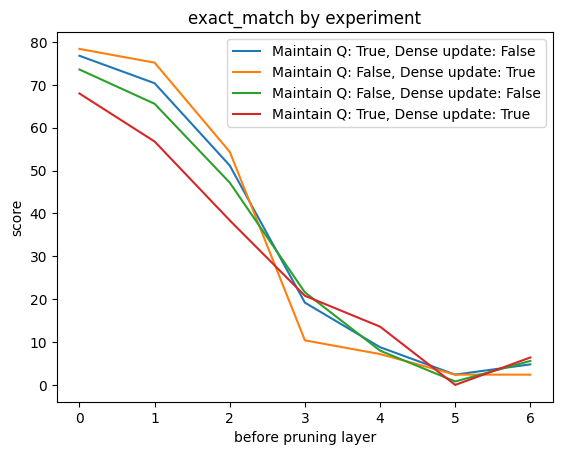

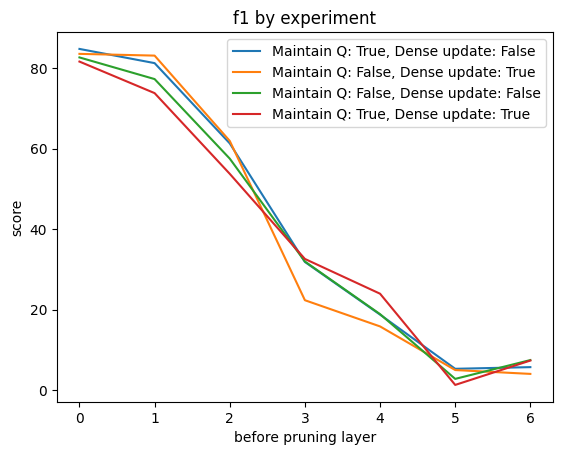

In [ ]:
import matplotlib.pyplot as plt

metrics = list(avgs_by_exp[0].keys())
metrics.remove('args')
for met in metrics:
  for exp in avgs_by_exp:
    data = exp[met]
    exp_args = exp['args']
    plt.plot(data, label=f"Maintain Q: {exp_args['maintain_Q']}, Dense update: {exp_args['dense_update']}")
  plt.legend()
  plt.ylabel('score')
  plt.xlabel('before pruning layer')
  plt.title(f'{met} by experiment')
  plt.show()
# for exp in avgs_by_exp:


## plot single exp, multiple runs

In [ ]:
with open(f'exp_2_all_results.json', 'r') as f:
  exp_data = json.load(f)

mets_by_score = []
for run in exp_data['metrics']: # all_run_mets is an array of dicts, each run should be a dict
  metrics = run['pre-pruning'].keys()
  run_metrics = {met: [0 for _ in run.keys()] for met in metrics}
  for i, layer in enumerate(run.keys()):
    for met in metrics:
      run_metrics[met][i] = run[layer][met]
  mets_by_score.append(run_metrics)

[{'exact_match': [76.0, 68.0, 48.0, 28.0, 8.0, 0.0, 8.0],
  'f1': [87.0,
   79.53333333333333,
   60.46969696969696,
   38.719047619047615,
   12.8,
   2.4421052631578943,
   9.263157894736842]},
 {'exact_match': [76.0, 68.0, 48.0, 28.0, 0.0, 0.0, 8.0],
  'f1': [87.0,
   79.53333333333335,
   56.43636363636363,
   42.02813852813853,
   10.904761904761905,
   3.067079463364293,
   13.076691729323308]},
 {'exact_match': [76.0, 60.0, 40.0, 12.0, 8.0, 0.0, 0.0],
  'f1': [84.54599914420197,
   76.43686330253496,
   54.51555555555556,
   20.73566268612708,
   21.635511441963054,
   1.4121052631578945,
   0.4056895485466914]},
 {'exact_match': [68.0, 56.0, 40.0, 32.0, 20.0, 0.0, 8.0],
  'f1': [82.81840966051492,
   72.37797524113314,
   55.86666666666667,
   39.460317460317455,
   34.35857214680744,
   1.1487179487179486,
   10.603263403263405]},
 {'exact_match': [72.0, 76.0, 60.0, 8.0, 4.0, 4.0, 4.0],
  'f1': [72.08791208791209,
   78.66666666666666,
   60.41025641025641,
   18.8839206770241

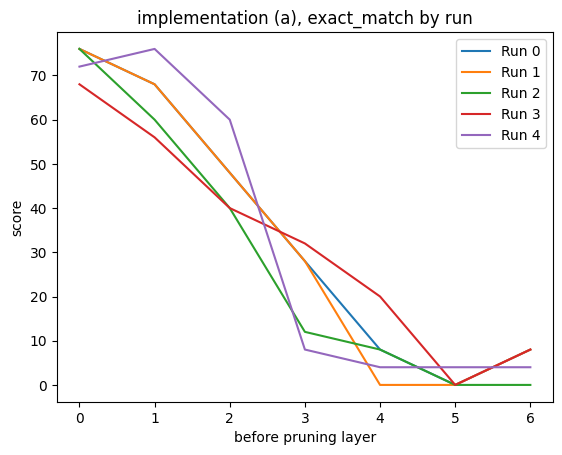

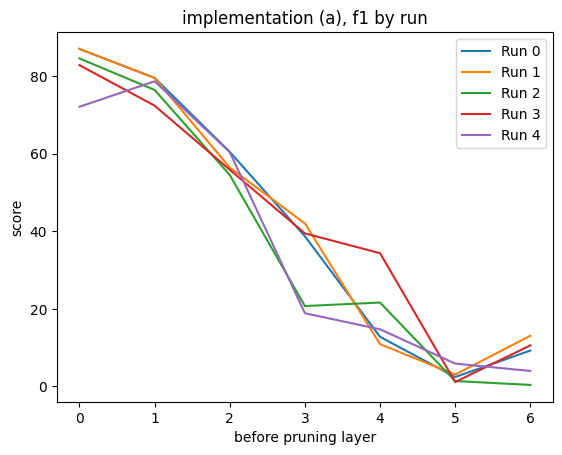

In [ ]:
import matplotlib.pyplot as plt

metrics = list(mets_by_score[0].keys())
for met in metrics:
  for i, exp in enumerate(mets_by_score):
    data = exp[met]
    plt.plot(data, label=f"Run {i}")
  plt.legend()
  plt.ylabel('score')
  plt.xlabel('before pruning layer')
  plt.title(f'implementation (a), {met} by run')
  plt.show()